In [1]:
import matplotlib.pyplot as plt
import re
import csv
from datetime import datetime

def plot_client_results(xlim):
    # Define the file paths
    input_file_path = 'status_thread.txt'

    # Initialize a dictionary to hold the data
    client_data = {}

    # Compile the regular expressions for matching lines
    client_regex = re.compile(r'client(\d+) stats:')
    
    # data_regex = re.compile(r'.*(\d+) operations; \[(READ|UPDATE): Count=(\d+) Max=\d+\.\d+ Min=\d+\.\d+ Avg=(\d+\.\d+) 90=\d+\.\d+ 99=(\d+\.\d+) 99.9=(\d+\.\d+) 99.99=\d+\.\d+\]')
    data_regex = re.compile(r'(\d{4}-\d{2}-\d{2} \d{2}:\d{2}:\d{2}).*operations; \[(READ|UPDATE): Count=(\d+) Max=\d+\.\d+ Min=\d+\.\d+ Avg=(\d+\.\d+) 90=\d+\.\d+ 99=(\d+\.\d+) 99.9=(\d+\.\d+) 99.99=\d+\.\d+\]')
    def timestamp_to_seconds(timestamp_str):
        timestamp = datetime.strptime(timestamp_str, '%Y-%m-%d %H:%M:%S')
        epoch = datetime(1970, 1, 1)
        return (timestamp - epoch).total_seconds()
    
    start_time = None
    
    # Open and read the input file
    with open(input_file_path, 'r') as file:
        lines = file.readlines()

        for i, line in enumerate(lines):
            client_match = client_regex.match(line)
            if client_match:
                client_id = client_match.group(1)
                # Check if the next line contains the data
                if i + 1 < len(lines):
                    data_match = data_regex.match(lines[i + 1])
                    if data_match:
                        # Extract the relevant data
                        # timestamp_str, _, count, avg, p99, p999 = data_match.group(2, 3, 4, 5, 6)
                        timestamp_str, _, count, avg, p99, p999 = data_match.group(1, 2, 3, 4, 5, 6)
                        if start_time is None:
                            start_time = timestamp_to_seconds(timestamp_str)

                        # Check if the client ID already exists in the dictionary
                        if client_id not in client_data:
                            client_data[client_id] = {'Count': [], 'Avg': [], '99': [], '999': []}
                        # Append the data to the lists in the dictionary
                        client_data[client_id]['Count'].append(count)
                        client_data[client_id]['Avg'].append(avg)
                        client_data[client_id]['99'].append(p99)
                        client_data[client_id]['999'].append(p999)
    # Function to plot data for all clients for a specific metric
    def plot_metric(metric, title, ylabel):
        plt.figure(figsize=(8, 5))
        for client_id, stats in client_data.items():
            time_points = [2 * i for i in range(len(stats[metric]))]
            if metric == 'Count':
                # Convert string values to integers for Count
                data_points = [int(x) for x in stats[metric]]
            else:
                # Convert string values to floats for Avg and 99
                data_points = [float(x) for x in stats[metric]]
            plt.plot(time_points, data_points, marker='o', label=f'Client {client_id}')
        
        plt.title(title)
        plt.xlabel('Time (s)')
        plt.xlim(xlim)
        plt.ylabel(ylabel)
        plt.legend()
        plt.grid(True)
        plt.show()

    # Plotting each metric
    plot_metric('Count', 'Count Over Time for All Clients', 'Count')
    plot_metric('Avg', 'Average Over Time for All Clients', 'Average')
    plot_metric('99', '99th Percentile Over Time for All Clients', '99th Percentile')
    return start_time


In [2]:
import matplotlib.pyplot as plt
import re
import json
from datetime import datetime
def plot_rocksdb_events(experiment_start_time, xlim):
    log_file_path = '/mnt/tgriggs-disk/ycsb-rocksdb-data/LOG'
    flush_regex = re.compile(
        r'(\d{4}/\d{2}/\d{2}-\d{2}:\d{2}:\d{2}\.\d{6}) \d+ \[/flush_job\.cc:\d+\] \[default\] \[JOB \d+\] Flush: (\d+) microseconds, \d+ cpu microseconds, (\d+) bytes'
    )
    l0_stall_pattern = re.compile(r'(\d{4}/\d{2}/\d{2}-\d{2}:\d{2}:\d{2}.\d{6}) \d+ \[WARN\] \[/column_family.cc:\d+\] \[default\] Stalling writes because we have \d+ level-0 files rate (\d+)')
    memtable_stall_pattern = re.compile(r'(\d{4}/\d{2}/\d{2}-\d{2}:\d{2}:\d{2}.\d{6}) \d+ \[WARN\] \[/column_family.cc:\d+\] \[default\] Stalling writes because we have \d+ immutable memtables.*rate (\d+)')

    compaction_regex = re.compile(r'.*EVENT_LOG_v1 (.*)$')
    def timestamp_to_seconds(timestamp_str):
        timestamp = datetime.strptime(timestamp_str, '%Y/%m/%d-%H:%M:%S.%f')
        epoch = datetime(1970, 1, 1)
        return (timestamp - epoch).total_seconds()

    def timestamp_to_micros(timestamp_str):
        timestamp_format = '%Y/%m/%d-%H:%M:%S.%f'
        dt = datetime.strptime(timestamp_str, timestamp_format)
        epoch = datetime(1970, 1, 1)
        micros_since_epoch = int((dt - epoch).total_seconds() * 1000000)
        return micros_since_epoch

    # Initialize lists for all events
    l0_stalls, memtable_stalls, flush_data, compaction_data = [], [], [], []

    # Process the log file for stall, flush, and compaction events
    with open(log_file_path, 'r') as log_file:
        for line in log_file:
            # L0 and Memtable Stalls
            l0_match = l0_stall_pattern.search(line)
            if l0_match:
                timestamp_str, rate = l0_match.groups()
                timestamp_micros = timestamp_to_micros(timestamp_str)
                l0_stalls.append((timestamp_micros, int(rate) / 1024 / 1024))

            memtable_match = memtable_stall_pattern.search(line)
            if memtable_match:
                timestamp_str, rate = memtable_match.groups()
                timestamp_micros = timestamp_to_micros(timestamp_str)
                memtable_stalls.append((timestamp_micros, rate))

            # Flush Events
            flush_match = flush_regex.match(line)
            if flush_match:
                timestamp_str, flush_microseconds, flush_bytes = flush_match.groups()
                start_time_seconds = timestamp_to_seconds(timestamp_str) - int(flush_microseconds) / 1e6
                rate_MB_s = (int(flush_bytes) / int(flush_microseconds)) * 1e6 / (1024**2)
                flush_data.append((start_time_seconds, rate_MB_s, int(flush_microseconds)/1e6))
            
            # Compaction Events
            compaction_match = compaction_regex.match(line)
            if compaction_match:
                json_str = compaction_match.group(1)
                event_data = json.loads(json_str)
                if event_data['event'] != 'compaction_finished':
                    continue
                start_time_seconds = event_data['time_micros'] / 1e6
                end_time_seconds = start_time_seconds + event_data['compaction_time_micros'] / 1e6
                read_rate = event_data['read_rate']
                write_rate = event_data['write_rate']
                compaction_data.append((start_time_seconds, end_time_seconds, read_rate, write_rate))

    # Determine the overall start time
    # all_start_times = [d[0] for d in flush_data + compaction_data + l0_stalls + memtable_stalls]
    # experiment_start_time = min(all_start_times)

    # Convert L0 and Memtable timestamps to seconds since experiment start
    l0_timestamps = [(timestamp_micros / 1e6) - experiment_start_time for timestamp_micros, _ in l0_stalls]
    l0_rates = [int(rate) for _, rate in l0_stalls]

    memtable_timestamps = [(timestamp_micros / 1e6) - experiment_start_time for timestamp_micros, _ in memtable_stalls]
    memtable_rates = [int(rate) for _, rate in memtable_stalls]

    # Plotting
    plt.figure(figsize=(8, 5))

    # Plot L0 and Memtable Stalls
    plt.scatter(l0_timestamps, l0_rates, label='L0 Stalls', color='black', s=10)
    plt.scatter(memtable_timestamps, memtable_rates, label='Memtable Stalls', color='grey', s=10)

    # Plot Flush Events
    for start_time, rate, duration in flush_data:
        plt.hlines(rate, start_time - experiment_start_time, (start_time + duration) - experiment_start_time, colors='green', linewidth=2, label='Flush' if flush_data.index((start_time, rate, duration)) == 0 else "")

    # Plot Compaction Events
    for start_time, end_time, read_rate, write_rate in compaction_data:
        plt.hlines(read_rate, start_time - experiment_start_time, end_time - experiment_start_time, colors='orange', linewidth=2, label='Compaction Read' if compaction_data.index((start_time, end_time, read_rate, write_rate)) == 0 else "")
        plt.hlines(write_rate, start_time - experiment_start_time, end_time - experiment_start_time, colors='red', linewidth=2, label='Compaction Write' if compaction_data.index((start_time, end_time, read_rate, write_rate)) == 0 else "")
    
    plt.title('Database Operations Over Time')
    plt.xlabel('Time (seconds since start of experiment)')
    plt.ylabel('Rate (MB/s) & Stalls')
    plt.xlim(xlim)
    plt.legend()
    plt.grid(True)
    plt.show()

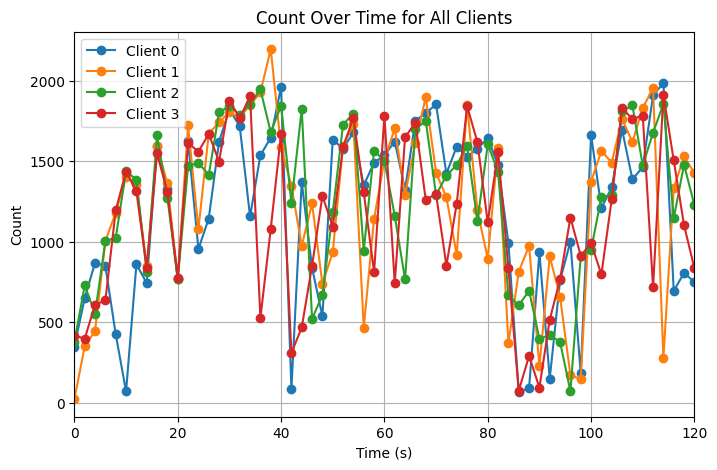

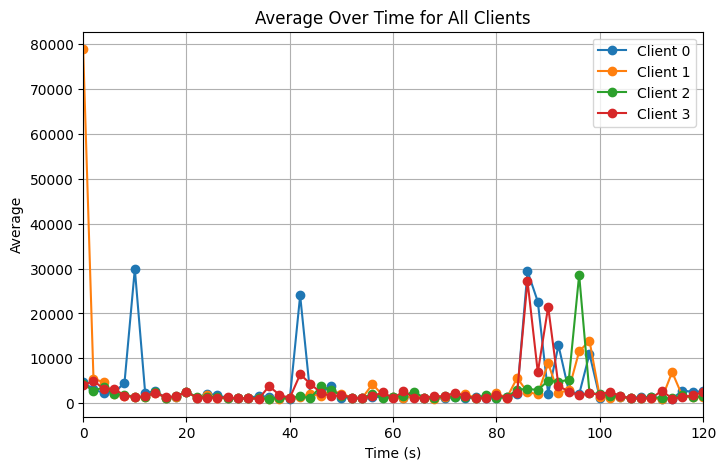

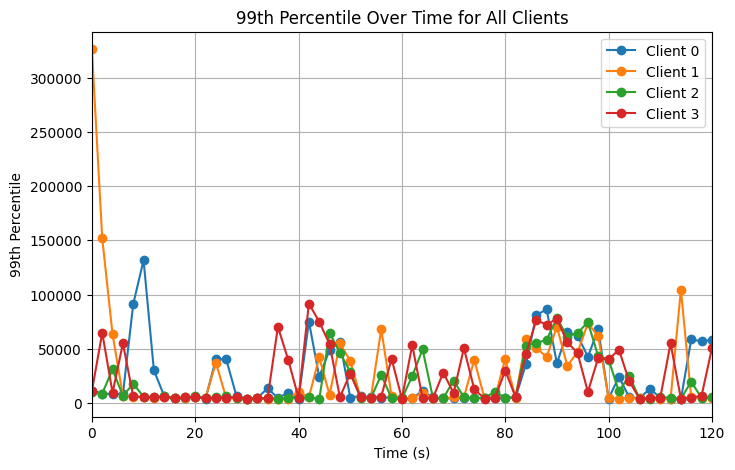

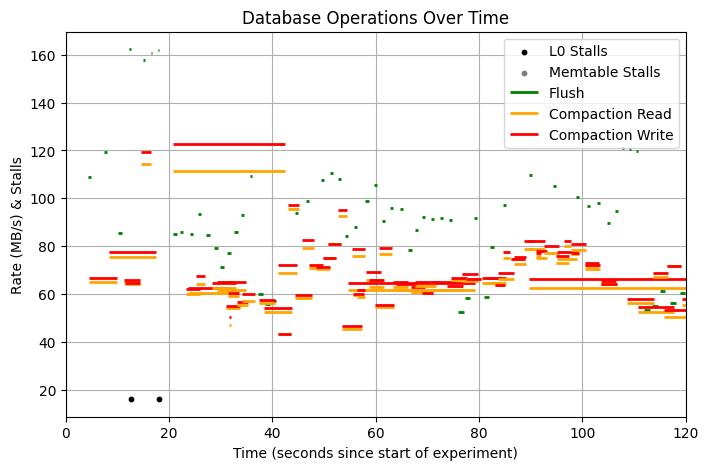

In [3]:
xlim = (0, 120)
start_time = plot_client_results(xlim)
plot_rocksdb_events(start_time, xlim)